Epoch 1/10
938/938 [==============================] - 46s 46ms/step - loss: 0.5434 - accuracy: 0.8007 - val_loss: 0.4100 - val_accuracy: 0.8527
Epoch 2/10
938/938 [==============================] - 43s 45ms/step - loss: 0.3482 - accuracy: 0.8741 - val_loss: 0.3370 - val_accuracy: 0.8793
Epoch 3/10
938/938 [==============================] - 43s 45ms/step - loss: 0.2941 - accuracy: 0.8937 - val_loss: 0.3076 - val_accuracy: 0.8888
Epoch 4/10
938/938 [==============================] - 43s 46ms/step - loss: 0.2620 - accuracy: 0.9055 - val_loss: 0.2904 - val_accuracy: 0.8990
Epoch 5/10
938/938 [==============================] - 44s 47ms/step - loss: 0.2386 - accuracy: 0.9128 - val_loss: 0.2694 - val_accuracy: 0.9051
Epoch 6/10
938/938 [==============================] - 44s 47ms/step - loss: 0.2174 - accuracy: 0.9215 - val_loss: 0.2671 - val_accuracy: 0.9041
Epoch 7/10
938/938 [==============================] - 44s 46ms/step - loss: 0.1992 - accuracy: 0.9274 - val_loss: 0.2622 - val_accuracy:

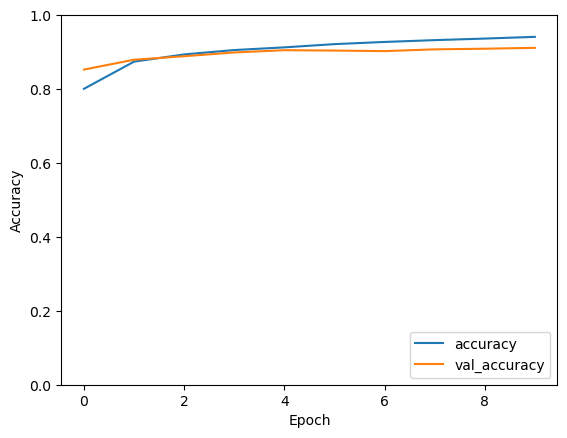

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

# Load the Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [2]:
model.save("xyz.h5") 


## Final code

In [2]:
import tkinter as tk
from PIL import Image, ImageTk
import cv2
import numpy as np
import mediapipe as mp
from keras.models import load_model
import time

# Load the trained model
model = load_model('xyz.h5')

# Define class labels for Fashion MNIST dataset
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

male_shirt_images = [
    cv2.imread(r"Shirts\1.png", -1),
    cv2.imread(r"Shirts\2.png", -1),
    cv2.imread(r"Shirts\3.png", -1),
    cv2.imread(r"Shirts\4.png", -1),
    cv2.imread(r"Shirts\5.png", -1),
    cv2.imread(r"Shirts\6.png", -1),
    cv2.imread(r"Shirts\7.png", -1),
    cv2.imread(r"Shirts\8.png", -1),
]

female_shirt_images = [
    cv2.imread(r"Shirts\10.png", -1),
    cv2.imread(r"Shirts\11.png", -1),
    cv2.imread(r"Shirts\12.png", -1),
    cv2.imread(r"Shirts\13.png", -1),
    cv2.imread(r"Shirts\16.png", -1),
    cv2.imread(r"Shirts\15.png", -1)
]

if any(image is None for image in male_shirt_images + female_shirt_images):
    raise ValueError("Error: Could not load one or more shirt images")

# Initialize Mediapipe pose and hand detection
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False, min_detection_confidence=0.3)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.3, min_tracking_confidence=0.5)

# Function to preprocess the webcam input
def preprocess_webcam_input(frame):
    # Resize the frame to match the input size of the model (28x28)
    resized_frame = cv2.resize(frame, (28, 28))
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    # Normalize pixel values to be in the range [0, 1]
    normalized = gray_frame.astype('float32') / 255
    # Reshape the input data to match the model's input shape
    input_data = normalized.reshape(1, 28, 28, 1)
    return input_data

# Function to overlay the shirt image on the frame
def overlay_shirt(frame, shirt_image, shoulders, upper_body_height):
    (left_shoulder, right_shoulder) = shoulders
    shoulder_width = abs(right_shoulder[0] - left_shoulder[0])
    shirt_width = int(shoulder_width * 1.8)  # Increase the width scaling factor
    shirt_height = int(shirt_image.shape[0] * (shirt_width / shirt_image.shape[1]))
    
    # Calculate the midpoint between the shoulders for centering the shirt
    mid_shoulder_x = int((left_shoulder[0] + right_shoulder[0]) / 2)
    shirt_x = mid_shoulder_x - int(shirt_width / 2)
    shirt_y = left_shoulder[1] - int(0.25 * upper_body_height)  # Start the shirt slightly above the shoulders
    
    # Ensure the shirt image fits within the frame
    if shirt_x < 0:
        shirt_x = 0
    if shirt_y < 0:
        shirt_y = 0
    if shirt_x + shirt_width > frame.shape[1]:
        shirt_width = frame.shape[1] - shirt_x
    if shirt_y + shirt_height > frame.shape[0]:
        shirt_height = frame.shape[0] - shirt_y
    
    # Ensure positive dimensions for resizing
    if shirt_width > 0 and shirt_height > 0:
        resized_shirt = cv2.resize(shirt_image, (shirt_width, shirt_height))
        alpha_s = resized_shirt[:, :, 3] / 255.0
        alpha_l = 1.0 - alpha_s

        for c in range(0, 3):
            frame[shirt_y:shirt_y+shirt_height, shirt_x:shirt_x+shirt_width, c] = (
                alpha_s * resized_shirt[:, :, c] + alpha_l * frame[shirt_y:shirt_y+shirt_height, shirt_x:shirt_x+shirt_width, c]
            )

# Function to classify clothes from webcam feed
def classify_clothes_from_webcam(gender, root):
    # Select shirt images based on gender
    if gender == 'male':
        shirt_images = male_shirt_images
    elif gender == 'female':
        shirt_images = female_shirt_images
    else:
        raise ValueError("Invalid gender selection")
    
    # Open the webcam
    cap = cv2.VideoCapture(0)
    current_shirt_index = 0
    hand_detected = False
    last_hand_detection_time = 0
    cooldown_period = 1  # Cooldown period in seconds
    
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocess the frame
        input_data = preprocess_webcam_input(frame)
        
        # Make prediction
        prediction = model.predict(input_data)
        predicted_class = np.argmax(prediction)
        label = class_labels[predicted_class]
        
        # Display the predicted label on the frame
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Use Mediapipe to detect pose landmarks
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pose_results = pose.process(frame_rgb)
        
        if pose_results.pose_landmarks:
            landmarks = pose_results.pose_landmarks.landmark
            
            # Get coordinates of left and right shoulders and hips
            left_shoulder = (int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x * frame.shape[1]),
                             int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y * frame.shape[0]))
            right_shoulder = (int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * frame.shape[1]),
                              int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * frame.shape[0]))
            left_hip = (int(landmarks[mp_pose.PoseLandmark.LEFT_HIP].x * frame.shape[1]),
                        int(landmarks[mp_pose.PoseLandmark.LEFT_HIP].y * frame.shape[0]))
            right_hip = (int(landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x * frame.shape[1]),
                         int(landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y * frame.shape[0]))
            
            # Calculate upper body height (distance between shoulders and hips)
            upper_body_height = int((left_hip[1] + right_hip[1]) / 2 - (left_shoulder[1] + right_shoulder[1]) / 2)
            
            # Overlay the shirt image if a shirt is detected
            if label in ['Shirt', 'T-shirt/top', 'Dress']:
                overlay_shirt(frame, shirt_images[current_shirt_index], (left_shoulder, right_shoulder), upper_body_height)
        
        # Use Mediapipe to detect hand landmarks
        hand_results = hands.process(frame_rgb)
        
        # Check for hands and manage the cooldown period
        if hand_results.multi_hand_landmarks:
            if not hand_detected:
                current_time = time.time()
                print(f"Hand detected at {current_time}, last detection at {last_hand_detection_time}")
                if current_time - last_hand_detection_time > cooldown_period:
                    print("Changing shirt image")
                    current_shirt_index = (current_shirt_index + 1) % len(shirt_images)
                    last_hand_detection_time = current_time
            hand_detected = True
        else:
            hand_detected = False
        
        # Display the frame
        cv2.imshow('Clothes Classification', frame)
        
        # Exit the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release the capture
    cap.release()
    cv2.destroyAllWindows()
    
    # Show the gender selection frame again
    gender_frame.pack(pady=50)

# Function to handle the start button click
def start_virtual_trial_room():
    # Hide the home page
    home_frame.pack_forget()

    # Show the gender selection frame
    gender_frame.pack(pady=50)

# Create the main application window
root = tk.Tk()
root.title("Virtual Trial Room")

# Set the window size
root.geometry("400x400")

# Load images for male and female
try:
    male_image = Image.open(r"male.png")
    female_image = Image.open(r"female.png")
except Exception as e:
    print(f"Error loading images: {e}")
    root.destroy()
    exit(1)

# Resize images if necessary
male_image = male_image.resize((100, 100), Image.LANCZOS)
female_image = female_image.resize((100, 100), Image.LANCZOS)

# Convert images to Tkinter PhotoImage
male_icon = ImageTk.PhotoImage(male_image)
female_icon = ImageTk.PhotoImage(female_image)

# Create the home frame
home_frame = tk.Frame(root)
home_frame.pack(pady=50)

# Create and place the title label in the home frame
title_label = tk.Label(home_frame, text="Virtual Trial Room", font=("Helvetica", 24))
title_label.pack(pady=10)

# Create and place the start button in the home frame
start_button = tk.Button(home_frame, text="Start", font=("Helvetica", 18), command=start_virtual_trial_room)
start_button.pack(pady=20)

# Create the gender selection frame
gender_frame = tk.Frame(root)

# Create and place the gender title label in the gender frame
gender_label = tk.Label(gender_frame, text="Gender", font=("Helvetica", 24))
gender_label.pack(pady=10)

# Create a frame for the gender buttons and images
gender_buttons_frame = tk.Frame(gender_frame)
gender_buttons_frame.pack(pady=20)

# Create and place the male button and image in the gender buttons frame
male_button = tk.Button(gender_buttons_frame, image=male_icon, text="Male", compound=tk.TOP, font=("Helvetica", 18), width=120,
                        command=lambda: classify_clothes_from_webcam('male', root))
male_button.image = male_icon  # Keep a reference to the image to prevent garbage collection
male_button.pack(side=tk.LEFT, padx=20)

# Create and place the female button and image in the gender buttons frame
female_button = tk.Button(gender_buttons_frame, image=female_icon, text="Female", compound=tk.TOP, font=("Helvetica", 18), width=120,
                          command=lambda: classify_clothes_from_webcam('female', root))
female_button.image = female_icon  # Keep a reference to the image to prevent garbage collection
female_button.pack(side=tk.RIGHT, padx=20)

# Keep references to the images to prevent garbage collection
root.male_icon = male_icon
root.female_icon = female_icon

# Run the application
root.mainloop()


1/1 [==============================] - 0s 21ms/step
Hand detected at 1718269060.5712717, last detection at 0
Changing shirt image
1/1 [==============================] - 0s 32ms/step
Hand detected at 1718269062.2483156, last detection at 1718269060.5712717
Changing shirt image
1/1 [==============================] - 0s 16ms/step
Hand detected at 1718269066.7177258, last detection at 1718269062.2483156
Changing shirt image
1/1 [==============================] - 0s 31ms/step
Hand detected at 1718269071.4833863, last detection at 1718269066.7177258
Changing shirt image
1/1 [==============================] - 0s 16ms/step
Hand detected at 1718269073.8526602, last detection at 1718269071.4833863
Changing shirt image
1/1 [==============================] - 0s 16ms/step
Hand detected at 1718269076.8365104, last detection at 1718269073.8526602
Changing shirt image
1/1 [==============================] - 0s 16ms/step
Hand detected at 1718269079.7663507, last detection at 1718269076.8365104
Changing 